## Importing Data and viewing overall

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)

train_df = pd.read_csv("train.csv", index_col="PassengerId")
final_test_df = pd.read_csv("test.csv", index_col="PassengerId")  

# print(train_df.info())
# print(train_df.head())
# print(final_test_df.info())
print(final_test_df.head())

# columns : ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket','Fare', 'Cabin', 'Embarked']




             Pclass                                          Name     Sex  \
PassengerId                                                                 
892               3                              Kelly, Mr. James    male   
893               3              Wilkes, Mrs. James (Ellen Needs)  female   
894               2                     Myles, Mr. Thomas Francis    male   
895               3                              Wirz, Mr. Albert    male   
896               3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

              Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
PassengerId                                                       
892          34.5      0      0   330911   7.8292   NaN        Q  
893          47.0      1      0   363272   7.0000   NaN        S  
894          62.0      0      0   240276   9.6875   NaN        Q  
895          27.0      0      0   315154   8.6625   NaN        S  
896          22.0      1      1  3101298  12.2875   NaN   

## Feature extraction based on insights drawn from other people's work
https://www.kaggle.com/imoore/titanic-the-only-notebook-you-need-to-see

-Cabin
-Family Size
-New way to impute age (using random, mean and std)
-Impute embarked with mode instead


In [2]:
combined_df = [train_df, final_test_df]
    
for df in combined_df:
    #Cabin
    df["HasCabin"] = 1 #Have
    df.loc[df["Cabin"].isna(),"HasCabin"] = 0 #Dont have
    #family size
    df["Family_Size"] = df["SibSp"] + df["Parch"] + 1
    #age
    age_mean = train_df["Age"].mean()
    age_std = train_df["Age"].std()
    rand_age = random.randint(int(age_mean-age_std), int(age_mean+age_std))
    df["Age"] = df["Age"].fillna(rand_age)
    #fare
    fare_mean = train_df["Fare"].mean()
    fare_std = train_df["Fare"].std()
    rand_fare = random.randint(int(fare_mean-fare_std), int(fare_mean+fare_std))
    df["Fare"] = df["Fare"].fillna(rand_fare)
    #Embarked
    df["Embarked"] = df["Embarked"].map({"C":0,"Q":1,"S":2})
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)
    #Sex
    df["Sex"] = df["Sex"].map({"male":1,"female":0})
    
  

In [3]:
#Dropping redundant columns
for df in combined_df:
    df.drop(["Name", "SibSp", "Parch", 'Ticket', 'Cabin'], axis=1, inplace=True)
    df["Embarked"].astype("int64")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    int64  
 1   Sex          418 non-null    int64  
 2   Age          418 non-null    float64
 3   Fare         418 non-null    float64
 4   Embarked     418 non-null    int64  
 5   HasCabin     418 non-null    int64  
 6   Family_Size  418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 26.1 KB


In [5]:
num_cols = ["Age", "Fare", "Family_Size"]
cat_cols = ["Pclass", "Sex", "HasCabin"]
output_var = ["Survived"]
print(train_df.head())

             Survived  Pclass  Sex   Age     Fare  Embarked  HasCabin  \
PassengerId                                                             
1                   0       3    1  22.0   7.2500       2.0         0   
2                   1       1    0  38.0  71.2833       0.0         1   
3                   1       3    0  26.0   7.9250       2.0         0   
4                   1       1    0  35.0  53.1000       2.0         1   
5                   0       3    1  35.0   8.0500       2.0         0   

             Family_Size  
PassengerId               
1                      2  
2                      2  
3                      1  
4                      2  
5                      1  


## Model Building

In [56]:
#Importing modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score

In [36]:
x_total = train_df.drop("Survived", axis=1)
y_total = train_df["Survived"]
x , x_test, y, y_test = train_test_split(x_total, y_total, stratify = y_total, test_size = 0.2)
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify = y, test_size = 0.2)


In [37]:
preprocess = ColumnTransformer(
    transformers = [
                    ('Standardscaler', StandardScaler(), num_cols),
                     ("Onehotencoder", OneHotEncoder(), cat_cols)
    ],
    remainder = 'passthrough'
    
)

pipeline_knn = make_pipeline(
            preprocess,
            KNeighborsClassifier())

pipeline_rf = make_pipeline(
            preprocess,
            RandomForestClassifier(random_state=42))



In [39]:
knn_hyper = {"kneighborsclassifier__n_neighbors" : list(range(1,11)),
            "kneighborsclassifier__leaf_size": list(range(1,26))
            }

model_knn = GridSearchCV(pipeline_knn, knn_hyper, cv=10, n_jobs=-1,scoring="roc_auc")

model_knn.fit(x_train,y_train.values.ravel())



GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Family_Size']),
                                                                        ('Onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['Pclass',
                                                                          'Sex',
                                                       

C:\Users\desto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_neighbors', ylabel='mean_test_score'>

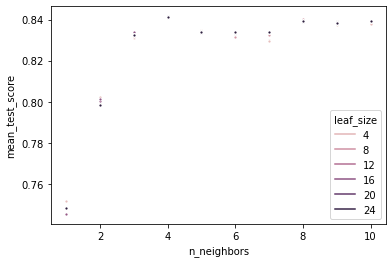

In [44]:
temp_knn = pd.DataFrame({'n_neighbors':model_knn.cv_results_['param_kneighborsclassifier__n_neighbors'], 'leaf_size': model_knn.cv_results_['param_kneighborsclassifier__leaf_size'], 'mean_test_score': model_knn.cv_results_['mean_test_score']})
sns.lineplot('n_neighbors', 'mean_test_score', hue= 'leaf_size',data=temp_knn, marker='.', linestyle='none')

C:\Users\desto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_neighbors', ylabel='mean_test_score'>

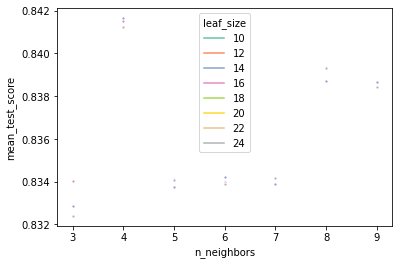

In [50]:
knn_hyper = {"kneighborsclassifier__n_neighbors" : list(range(3,10)),
            "kneighborsclassifier__leaf_size": list(range(10,26,2))
            }

model_knn = GridSearchCV(pipeline_knn, knn_hyper, cv=10, n_jobs=-1,scoring="roc_auc")

model_knn.fit(x_train,y_train.values.ravel())

temp_knn2 = pd.DataFrame({'n_neighbors':model_knn.cv_results_['param_kneighborsclassifier__n_neighbors'], 'leaf_size': model_knn.cv_results_['param_kneighborsclassifier__leaf_size'], 'mean_test_score': model_knn.cv_results_['mean_test_score']})
sns.lineplot('n_neighbors', 'mean_test_score', hue= 'leaf_size',data=temp_knn2, marker='.', linestyle='none',palette='Set2')


C:\Users\desto\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_neighbors', ylabel='mean_test_score'>

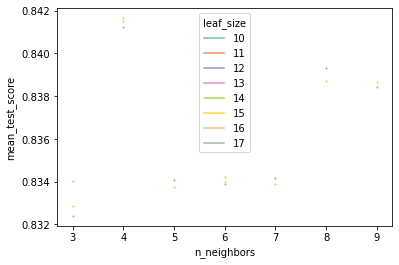

In [51]:
knn_hyper = {"kneighborsclassifier__n_neighbors" : list(range(3,10)),
            "kneighborsclassifier__leaf_size": list(range(10,18))
            }

model_knn = GridSearchCV(pipeline_knn, knn_hyper, cv=10, n_jobs=-1,scoring="roc_auc")

model_knn.fit(x_train,y_train.values.ravel())

temp_knn2 = pd.DataFrame({'n_neighbors':model_knn.cv_results_['param_kneighborsclassifier__n_neighbors'], 'leaf_size': model_knn.cv_results_['param_kneighborsclassifier__leaf_size'], 'mean_test_score': model_knn.cv_results_['mean_test_score']})
sns.lineplot('n_neighbors', 'mean_test_score', hue= 'leaf_size',data=temp_knn2, marker='.', linestyle='none',palette='Set2')


In [53]:
print(model_knn.best_params_, model_knn.best_score_)

{'kneighborsclassifier__leaf_size': 10, 'kneighborsclassifier__n_neighbors': 4} 0.8416388373531232


In [57]:
model_knn.best_estimator_.fit(x_train, y_train)
model_knn_preds = model_knn.best_estimator_.predict(x_val)
roc_auc_score(y_val,model_knn_preds)

0.8295454545454546

In [58]:
rf_hyper = {'randomforestclassifier__n_estimators' : range(100,500,100),
           'randomforestclassifier__max_depth': range(2,10),
           'randomforestclassifier__min_samples_leaf' : range(1,8),
           'randomforestclassifier__max_features' : range(2,9)}

model_rf = RandomizedSearchCV(pipeline_rf, rf_hyper, cv=10, n_iter=25, n_jobs=-1,scoring="roc_auc")

model_rf.fit(x_train,y_train.values.ravel())


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('Standardscaler',
                                                                               StandardScaler(),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'Family_Size']),
                                                                              ('Onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['Pclass',
                                                                      

In [76]:
print(pd.DataFrame({'max_depth': model_rf.cv_results_['param_randomforestclassifier__max_depth'], 'score': model_rf.cv_results_['mean_test_score']}).sort_values(by='max_depth', axis=0))
print(pd.DataFrame({'max_features': model_rf.cv_results_['param_randomforestclassifier__max_features'], 'score': model_rf.cv_results_['mean_test_score']}).sort_values(by='max_features', axis=0))
print(pd.DataFrame({'min_samples_leaf': model_rf.cv_results_['param_randomforestclassifier__min_samples_leaf'], 'score': model_rf.cv_results_['mean_test_score']}).sort_values(by='min_samples_leaf', axis=0))
print(pd.DataFrame({'n_estimators': model_rf.cv_results_['param_randomforestclassifier__n_estimators'], 'score': model_rf.cv_results_['mean_test_score']}).sort_values(by='n_estimators', axis=0))

   max_depth     score
19         2  0.850045
23         2  0.845440
0          3  0.856361
1          4  0.861076
2          4  0.862510
22         4  0.861958
6          4  0.863045
7          4  0.856472
4          5  0.857013
21         5  0.856666
20         5  0.861441
10         5  0.856402
16         5  0.862888
12         6  0.856996
11         6  0.860262
9          6  0.855823
13         6  0.856884
24         6  0.861394
15         7  0.856564
17         7  0.857510
8          7  0.860360
18         8  0.861336
3          8  0.860449
14         9  0.859105
5          9  0.861494
   max_features     score
1             2  0.861076
16            2  0.862888
11            2  0.860262
5             2  0.861494
12            3  0.856996
7             3  0.856472
24            3  0.861394
6             3  0.863045
15            4  0.856564
23            4  0.845440
0             4  0.856361
3             5  0.860449
18            5  0.861336
22            5  0.861958
13          

In [79]:
model_rf.best_estimator_.fit(x_train, y_train)
model_rf_preds = model_rf.best_estimator_.predict(x_val)
roc_auc_score(y_val, model_rf_preds)

0.8636363636363636

In [80]:
best_knn_model = model_knn.best_estimator_

best_rf_model = model_rf.best_estimator_

In [81]:
clfs = [("KNN", best_knn_model),
       ("RF", best_rf_model)]

In [82]:
new_model=VotingClassifier(estimators=clfs)

In [83]:
new_model.fit(x_train,y_train.values.ravel())

VotingClassifier(estimators=[('KNN',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('Standardscaler',
                                                                                StandardScaler(),
                                                                                ['Age',
                                                                                 'Fare',
                                                                                 'Family_Size']),
                                                                               ('Onehotencoder',
                                                                                OneHotEncoder(),
                                                                                ['Pclass',
                                                 

In [85]:
pred_test = new_model.predict(x_val)

In [87]:
print(confusion_matrix(y_val,pred_test))
print(classification_report(y_val,pred_test))
print(roc_auc_score(y_val,pred_test))

[[83  5]
 [16 39]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        88
           1       0.89      0.71      0.79        55

    accuracy                           0.85       143
   macro avg       0.86      0.83      0.84       143
weighted avg       0.86      0.85      0.85       143

0.8261363636363636


### seems like the RF model performed the best based on ROC_AUC

In [88]:
final_knn_preds = model_knn.predict(x_test)
final_rf_preds = model_rf.predict(x_test)
final_voting_preds = new_model.predict(x_test)

print("KNN: ", roc_auc_score(y_test, final_knn_preds))
print("RF: ", roc_auc_score(y_test, final_rf_preds))
print("VotingClassifier: ", roc_auc_score(y_test, final_voting_preds))

KNN:  0.7351778656126482
RF:  0.7904479578392621
VotingClassifier:  0.7570487483530962


In [95]:
new_pred_final = model_rf.predict(final_test_df)

In [96]:
final_test_df2 = pd.read_csv("test.csv")
submission2 = pd.concat([final_test_df2["PassengerId"], pd.Series(new_pred_final,name="Survived")],axis=1)

In [97]:
submission2

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [99]:
submission2.to_csv("Submission V2.csv", index=False)
#seems like this was worst than the first time

In [102]:
new_pred_final2 = new_model.predict(final_test_df)
submission2_2 = pd.concat([final_test_df2["PassengerId"], pd.Series(new_pred_final2,name="Survived")],axis=1)

In [103]:
submission2_2.to_csv("Submission V2_2.csv", index=False)
#also worst

0.8113450429964191
0.8636363636363636


In [ ]:
fpr, tpr, threshold = roc_curve(y_test, pred_test)

In [ ]:
print(auc(fpr,tpr))
print(classification_report(y_test,pred_test))

In [ ]:
pred_knn = model_knn.predict(x_test)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, pred_knn)
print(auc(fpr_knn, tpr_knn))
print(classification_report(y_test,pred_knn))

In [ ]:
pred_rf = model_rf.predict(x_test)
fpr_rf, tpr_rf, threshold_knn = roc_curve(y_test, pred_rf)
print(auc(fpr_rf, tpr_rf))
print(classification_report(y_test,pred_rf))